# Style Transfer - (1 Base Image 2 Style Images)
 - Feel free to check out my [1 Base Image 1 Style Image](http://35.165.212.8:8888/notebooks/wk8-generate-art/Generate-art-style-transform1.ipynb)

In [1]:
import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


## Images Preprocessing

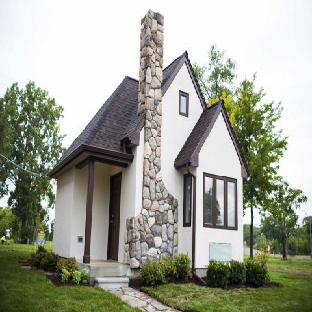

In [2]:
height = 312
width = 312

# Base Image
content_image = Image.open('house.jpg')
content_image = content_image.resize((height,width))
content_image

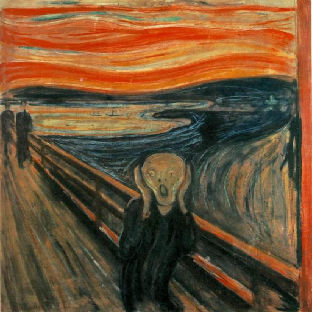

In [3]:
# Style Image 1
style_image1 = Image.open('the_scream.jpg')
style_image1 = style_image1.resize((height,width))
style_image1

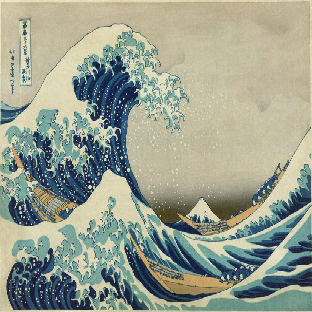

In [4]:
# Style Image 2
style_image2 = Image.open('wave.jpg')
style_image2 = style_image2.resize((height,width))
style_image2

In [5]:
# Convert content image to numerical data
content_array = np.asarray(content_image, dtype='float32')
content_array.shape

(312, 312, 3)

In [6]:
# Then add one dimension
content_array = np.expand_dims(content_array, axis=0)
content_array.shape

(1, 312, 312, 3)

In [7]:
# Convert style image to numerical data, then add one dimension
style_array1 = np.asarray(style_image1, dtype='float32')
style_array1 = np.expand_dims(style_array1, axis=0)
style_array1.shape

(1, 312, 312, 3)

In [8]:
style_array2 = np.asarray(style_image2, dtype='float32')
style_array2 = np.expand_dims(style_array2, axis=0)
style_array2.shape

(1, 312, 312, 3)

In [9]:
# subtract RGB mean and RGB reverse ordering (RGB -> BGR)
content_array[:,:,:,0] -= 103.939 # R mean
content_array[:,:,:,1] -= 116.779 # G mean
content_array[:,:,:,2] -= 123.68  # B mean
content_array = content_array[:,:,:,::-1] 

In [10]:
style_array1[:,:,:,0] -= 103.939
style_array1[:,:,:,1] -= 116.779
style_array1[:,:,:,2] -= 123.68
style_array1 = style_array1[:,:,:,::-1] # RGB -> BGR

In [11]:
style_array2[:,:,:,0] -= 103.939
style_array2[:,:,:,1] -= 116.779
style_array2[:,:,:,2] -= 123.68
style_array2 = style_array2[:,:,:,::-1] # RGB -> BGR

In [12]:
# making it ready for VGG16
content_image = backend.variable(content_array)
style_image1 = backend.variable(style_array1)
style_image2 = backend.variable(style_array2)
combination_image = backend.placeholder((1,height,width,3))

In [13]:
input_tensor = backend.concatenate([content_image,style_image1,style_image2,combination_image], axis=0)

In [14]:
input_tensor

<tf.Tensor 'concat:0' shape=(4, 312, 312, 3) dtype=float32>

## VGG 16 pre-trained filters

In [15]:
# No need last FC layers
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [16]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (4, 312, 312, 3)      0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (4, 312, 312, 64)     1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (4, 312, 312, 64)     36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (4, 156, 156, 64)     0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [17]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'Relu:0' shape=(4, 312, 312, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'Relu_1:0' shape=(4, 312, 312, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'MaxPool:0' shape=(4, 156, 156, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'Relu_2:0' shape=(4, 156, 156, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'Relu_3:0' shape=(4, 156, 156, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'MaxPool_1:0' shape=(4, 78, 78, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'Relu_4:0' shape=(4, 78, 78, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'Relu_5:0' shape=(4, 78, 78, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'Relu_6:0' shape=(4, 78, 78, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'MaxPool_2:0' shape=(4, 39, 39, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'Relu_7:0' shape=(4, 39, 39, 512) dtype=float32>,
 'block4_conv2': <tf.Tensor 'Relu_8:0' shape=(4, 39, 39, 512) dtype=float32>,
 'block4_conv3': <tf.Tensor 'Relu_9:0' shape=(4, 39, 39

In [18]:
layers['block2_conv2'][0,:,:,:]

<tf.Tensor 'strided_slice:0' shape=(156, 156, 128) dtype=float32>

In [60]:
# Weights hyperparameters for 3 losses: Content Loss, Style loss, total variation loss
content_weight = 0.025 #1.0
style_weight1 = 2.0   #5.2 #10.2
style_weight2 = 2.5 #5.0 #10.0
total_variation_weight = 1.0

In [61]:
# initialize the loss 
loss = backend.variable(0.)

## The Content Loss

In [62]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

# For content we only use the VGG layer - [block2_conv2]
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[3, :, :, :]

loss += content_weight * content_loss(content_image_features, combination_features)

## The Style Loss

In [63]:
# For style loss we gonna adopt Gram Matrix because it can abstract better
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [64]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# For style loss we gonna use following layers from VGG16
feature_layers = ['block1_conv2', 'block2_conv2','block3_conv3', 'block4_conv3','block5_conv3']

# Apply Style image 1
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[3, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight1 / len(feature_layers)) * sl

# Apply Style image 2
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[2, :, :, :]
    combination_features = layer_features[3, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight2 / len(feature_layers)) * sl

## The Total Variation Loss

In [65]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

## Gradient Loss Optimization

In [66]:
grads = backend.gradients(loss, combination_image)

In [67]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [68]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 30

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 1.28336e+11
Iteration 0 completed in 20s
Start of iteration 1
Current loss value: 9.65177e+10
Iteration 1 completed in 21s
Start of iteration 2
Current loss value: 9.03551e+10
Iteration 2 completed in 20s
Start of iteration 3
Current loss value: 8.80875e+10
Iteration 3 completed in 20s
Start of iteration 4
Current loss value: 8.6596e+10
Iteration 4 completed in 20s
Start of iteration 5
Current loss value: 8.58016e+10
Iteration 5 completed in 20s
Start of iteration 6
Current loss value: 8.52153e+10
Iteration 6 completed in 20s
Start of iteration 7
Current loss value: 8.48067e+10
Iteration 7 completed in 20s
Start of iteration 8
Current loss value: 8.45395e+10
Iteration 8 completed in 20s
Start of iteration 9
Current loss value: 8.43419e+10
Iteration 9 completed in 21s
Start of iteration 10
Current loss value: 8.42181e+10
Iteration 10 completed in 20s
Start of iteration 11
Current loss value: 8.41204e+10
Iteration 11 completed in 20s
Start of iter

## Output
I have tried different hyperparameters to see the different effects.
- 1st try: high content weight; it is obvious that two styles are not transferred much. The output has little impacts from styles. 
- 2nd try: I have lowered the content weight. The output image has shown strong impacts from both style images.
- 3rd try: a better denoising process
- 4th try: further denoising process

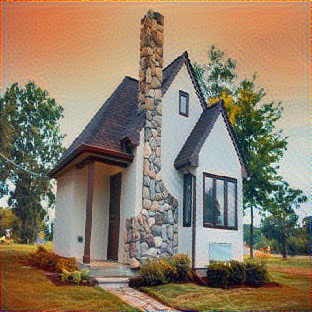

In [28]:
# 1st try --- content_weight=1.0, style_weight1=10.2, style_weight2=10.0, total_variation_weight=1.0, iterations=30

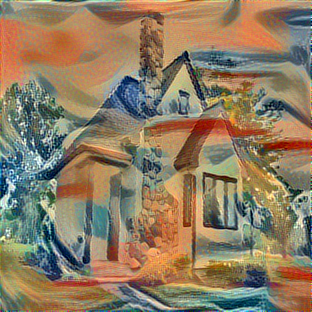

In [38]:
# 2nd try --- content_weight=0.025, style_weight1=5.2, style_weight2=5.0, total_variation_weight=1.0, iterations=5

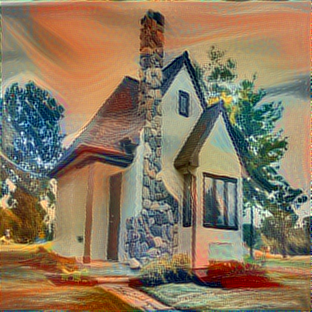

In [59]:
# 3rd try --- content_weight=0.025, style_weight1=3.2, style_weight2=3.0, total_variation_weight=1.0, iterations=5

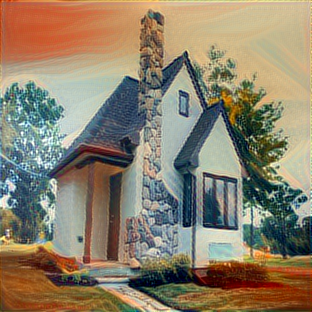

In [69]:
# 4th try --- content_weight=0.025, style_weight1=2.0, style_weight2=2.5, total_variation_weight=1.0, iterations=30
x = x.reshape((height, width, 3))
x = x[:, :, ::-1] # BGR -> RGB
x[:, :, 0] += 103.939 # Mean R
x[:, :, 1] += 116.779 # Mean G
x[:, :, 2] += 123.68  # Mean B
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)